Total params: 190,770

Training Accuracy: 96.17%

Validation Accuracy: 86.69%

Test Accuracy: 84.04%

Quantization Accuracy: 74.84% (74.841%)

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import shutil
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Conv2D
from tensorflow.keras.optimizers import Adam

In [2]:
BATCH_SIZE = 128
# You may need to lower this depending upon your GPU

TARGET_SIZE = (88, 88)
# This model uses 88x88 images

In [3]:
# These were created as part of our data preparation notebook
filtered_train_storage_ds = "C:/colab/data/birds/cached/filtered/train"
filtered_valid_storage_ds = "C:/colab/data/birds/cached/filtered/valid"
filtered_test_storage_ds = "C:/colab/data/birds/cached/filtered/test"

In [4]:
# Generator
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    brightness_range=[0.75,1.15],
    rotation_range=30,
    channel_shift_range=10,
    width_shift_range=1.0,
    height_shift_range=1.0,
    shear_range=0.02,
    horizontal_flip=True,
    fill_mode='reflect',
)

# Many folks are against validation augmentation but I use it as the changes
# here are mostly minimal and gives more variation. The test generator is pure.
validation_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    brightness_range=[0.75,1.15],
    rotation_range=30,
    channel_shift_range=10,
    fill_mode='reflect',
    validation_split=0.2,
    horizontal_flip=True,
)


test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
)

In [5]:
train_images = train_generator.flow_from_directory(
    directory=filtered_train_storage_ds,
    interpolation='bilinear',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
)

val_images = validation_generator.flow_from_directory(
    directory=filtered_valid_storage_ds,
    interpolation='bilinear',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
)

test_images = test_generator.flow_from_directory(
    directory=filtered_test_storage_ds,
    interpolation='bilinear',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 42596 images belonging to 411 classes.
Found 10554 images belonging to 411 classes.
Found 13292 images belonging to 411 classes.


Train images:


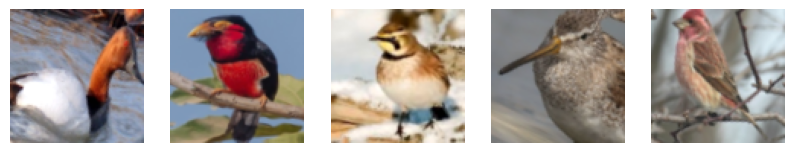

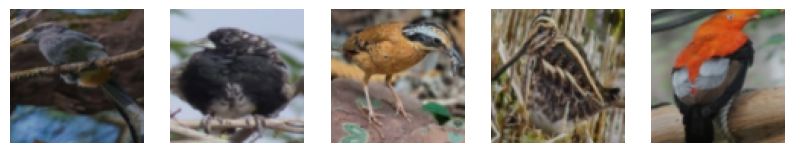

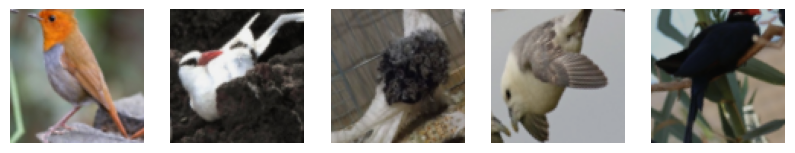

Validation images:


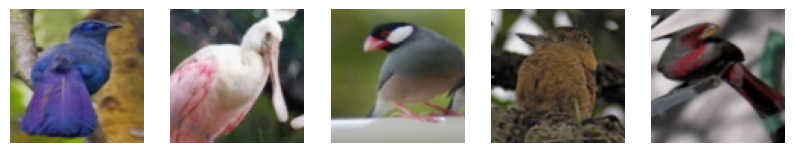

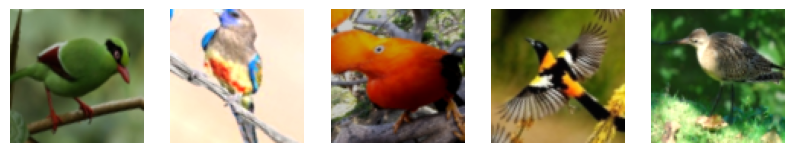

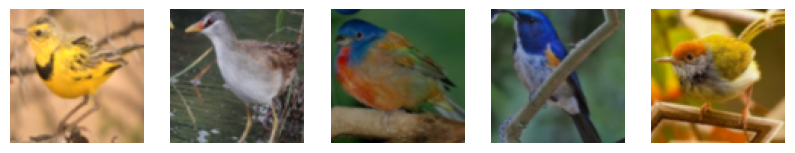

Test images:


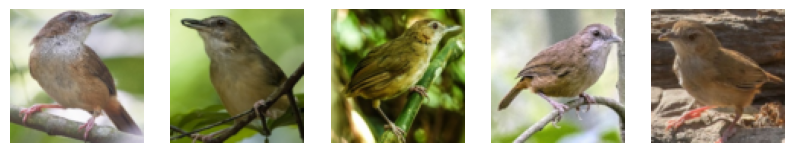

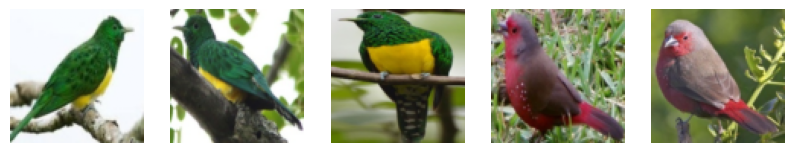

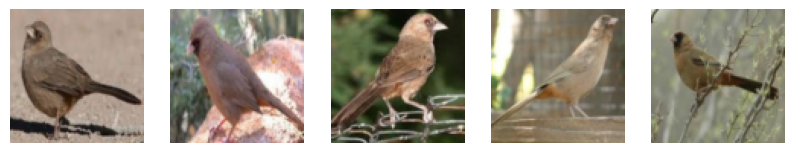

In [6]:
# Visualize the images
def visualize_generator(generator, samples = 5):
    batch_images, labels = next(generator)
    plt.figure(figsize=(10,5))
    for i in range(samples):
        plt.subplot(1, samples, i+1)
        plt.imshow(batch_images[i] / 255.0)
        plt.axis('off')
    plt.show()
    batch_images, labels = next(generator)
    plt.figure(figsize=(10,5))
    for i in range(samples):
        plt.subplot(1, samples, i+1)
        plt.imshow(batch_images[i+5] / 255.0)
        plt.axis('off')
    plt.show()
    batch_images, labels = next(generator)
    plt.figure(figsize=(10,5))
    for i in range(samples):
        plt.subplot(1, samples, i+1)
        plt.imshow(batch_images[i+10] / 255.0)
        plt.axis('off')
    plt.show()

print("Train images:")
visualize_generator(train_images)

print("Validation images:")
visualize_generator(val_images)

print("Test images:")
visualize_generator(test_images)

In [6]:
# absolute-cosine regularization
# https://www.amazon.science/publications/quantization-aware-training-with-absolute-cosine-regularization-for-automatic-speech-recognition
class ACosR(tf.keras.regularizers.Regularizer):
    def __init__(self, weight=1.0):
        self.weight = weight

    def __call__(self, weights):
        # Calculate the absolute cosine similarity
        cos_similarity = tf.reduce_mean(tf.abs(tf.reduce_sum(weights * tf.roll(weights, shift=1, axis=-1), axis=-1)))

        # Apply the regularization term to the loss
        regularization_loss = self.weight * cos_similarity

        return regularization_loss

    def get_config(self):
        return {'weight': float(self.weight)}


In [7]:
# Load the pretrained model
pretrained_model = tf.keras.applications.EfficientNetB0(input_shape=(88, 88, 3), include_top=False, weights='imagenet')
pretrained_model.trainable = False
selected_layer_index = 87
pretrained_model.layers[2]._name = 'normalization'

# Enable ACosR
for i in range(0, len(pretrained_model.layers)):
    layer = pretrained_model.layers[i]
    if isinstance(layer, keras.layers.Conv2D) or isinstance(layer, keras.layers.DepthwiseConv2D):
        pretrained_model.layers[i].kernel_regularizer = ACosR(weight = 0.005)

for i in range(0, len(pretrained_model.layers)):
    if hasattr(pretrained_model.layers[i], "activation"):
        if "swish" in str(pretrained_model.layers[i].activation):
            pretrained_model.layers[i].activation = tf.keras.activations.relu

selected_layer_output = pretrained_model.layers[selected_layer_index].output
x = selected_layer_output
x = Conv2D(240, 1, groups=2, trainable=False, name="conv_s1", padding='valid', kernel_regularizer = ACosR(weight = 0.005))(x)
x = tf.keras.layers.BatchNormalization(trainable = False, name='tbd-b1')(x)
x = tf.keras.layers.Activation(tf.keras.activations.relu)(x)

x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(180, trainable = False, kernel_regularizer = ACosR(weight = 0.005), name="dense_s_1", activation='relu')(x)
x = Dense(50, trainable = False, kernel_regularizer = ACosR(weight = 0.005), name="dense_2", activation='relu')(x)
outputs = Dense(411, kernel_regularizer = ACosR(weight = 0.005), trainable = False, activation=tf.keras.activations.softmax, name="dense_output")(x)
model = Model(inputs=pretrained_model.input, outputs=outputs)
model.load_weights('C:/colab/data/birds/saves/88x88_411_full_relu_post_decimation/saved_model')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 88, 88, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 88, 88, 3)    0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 88, 88, 3)    7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 88, 88, 3)    0           ['normalization[0][0]']          
                                                                                              

In [8]:
# All layers are locked but running an epoch for demonstration purposes
model.compile(
    optimizer=Adam(1e-6),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=1,
)

333/333 [==============================] - 191s 563ms/step - loss: 0.1326 - accuracy: 0.9620 - val_loss: 0.6808 - val_accuracy: 0.8655


In [9]:
# Now let's evaluate the test images against this checkpoint

results = model.evaluate(test_images, verbose=1)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

104/104 [==============================] - 8s 81ms/step - loss: 0.8327 - accuracy: 0.8404
    Test Loss: 0.83271
Test Accuracy: 84.04%


In [10]:
# Let's now run predictions against the test images and show the output
# for a random subset as a grid
pred = model.predict(test_images)
pred = np.argmax(pred, axis=1)

# Map the label
labels = (test_images.class_indices)
labels = dict((v, k) for k, v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

# Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_images.filepaths), 25)
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(25, 25), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_images.filepaths[random_index[i]]))
    true_label = labels[test_images.classes[random_index[i]]]
    predicted_label = pred[random_index[i]]
    if true_label == predicted_label:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {true_label}\nPredicted: {predicted_label}", color=color)

plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [11]:
# Classification report
y_test = [labels[idx] for idx in test_images.classes]
print(classification_report(y_test, pred))

                               precision    recall  f1-score   support

              ABBOTTS BABBLER       0.65      0.73      0.69        33
                ABBOTTS BOOBY       0.59      0.56      0.57        36
   ABYSSINIAN GROUND HORNBILL       0.82      0.86      0.84        36
       AFRICAN EMERALD CUCKOO       0.72      0.68      0.70        31
            AFRICAN FIREFINCH       0.69      0.81      0.75        27
       AFRICAN OYSTER CATCHER       0.94      0.97      0.95        31
        AFRICAN PIED HORNBILL       0.81      0.70      0.75        37
                    ALBATROSS       0.70      0.73      0.72        26
               ALBERTS TOWHEE       0.79      0.69      0.73        32
         ALEXANDRINE PARAKEET       0.94      0.94      0.94        33
                ALPINE CHOUGH       0.89      0.97      0.93        33
        ALTAMIRA YELLOWTHROAT       0.88      0.77      0.82        30
              AMERICAN AVOCET       0.97      0.97      0.97        36
     

In [12]:
# https://keras.io/examples/vision/grad_cam/

def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        inputs = model.inputs, outputs = [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    # Save the superimposed image
    superimposed_img.save(cam_path)
    return cam_path

preprocess_input = tf.keras.applications.efficientnet.preprocess_input
decode_predictions = tf.keras.applications.efficientnet.decode_predictions

last_conv_layer_name = "conv_s1"
img_size = (88, 88, 3)

# Remove last layer's softmax
model.layers[-1].activation = None

In [13]:
# Let's now run predictions against the test images and show the output
# for a random subset as a grid
pred = model.predict(test_images)
pred = np.argmax(pred, axis=1)

# Map the label
labels = (test_images.class_indices)
labels = dict((v, k) for k, v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

# Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_images.filepaths), 25)
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(25, 25), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_images.filepaths[random_index[i]]))
    true_label = labels[test_images.classes[random_index[i]]]
    predicted_label = pred[random_index[i]]
    if true_label == predicted_label:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {true_label}\nPredicted: {predicted_label}", color=color)

plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [14]:
# Display the part of the pictures used by the neural network to classify the pictures
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = test_images.filepaths[random_index[i]]
    img_array = tf.keras.applications.efficientnet.preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"True: {labels[test_images.classes[random_index[i]]]}\nPredicted: {pred[random_index[i]]}")
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [15]:
# Quantization
tflite_model_path = 'C:/colab/data/birds/bird_classifier_88x88_411.tflite'
test_extra_ds = "C:/colab/data/birds/test"


quantization_image_set = test_generator.flow_from_directory(
    directory=filtered_test_storage_ds,
    interpolation='bilinear',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True
)

def representative_dataset():
    i = 0
    for input_data, _ in quantization_image_set:
        yield [input_data]

        if i >= 6:
           break
        i += 1

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
converter.representative_dataset = representative_dataset

# Convert the model
tflite_model_int8 = converter.convert()

# Save the converted INT8 quantized model
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model_int8)

Found 13292 images belonging to 411 classes.


INFO:tensorflow:Assets written to: C:\Users\Osenin\AppData\Local\Temp\tmp67t6fmg9\assets


INFO:tensorflow:Assets written to: C:\Users\Osenin\AppData\Local\Temp\tmp67t6fmg9\assets
C:\Users\Osenin\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [16]:
# Using a smaller batch size
test_images = test_generator.flow_from_directory(
    directory=filtered_test_storage_ds,
    interpolation='bilinear',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

tflite_interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

tflite_interpreter.resize_tensor_input(input_details[0]['index'], (32, 88, 88, 3))
tflite_interpreter.resize_tensor_input(output_details[0]['index'], (32, 5))
tflite_interpreter.allocate_tensors()

input_batch, _ = next(test_images)

results = []
average_accuracy = 0
for i in range(len(test_images)):
    batch = test_images[i]
    input_batch, labels = batch
    image_input_batch = tf.cast(input_batch, tf.int8)

    input_scale, input_zero_point = input_details[0]["quantization"]
    image_input_batch = tf.cast(image_input_batch, tf.float32)
    image_input_batch = (image_input_batch / input_scale) + input_zero_point
    image_input_batch = tf.cast(image_input_batch, tf.int8)
    if len(image_input_batch) == 32:
        tflite_interpreter.set_tensor(input_details[0]['index'], image_input_batch)
        tflite_interpreter.invoke()
        tflite_model_predictions = tflite_interpreter.get_tensor(output_details[0]['index'])

        tflite_predicted_ids = np.argmax(tflite_model_predictions, axis=-1)
        tflite_label_id = np.argmax(labels, axis=-1)

        correct_predictions = np.sum(tflite_predicted_ids == tflite_label_id)
        total_predictions = len(tflite_predicted_ids)
        accuracy_percentage = (correct_predictions / total_predictions) * 100

        results.append(accuracy_percentage)
        average_accuracy = sum(results) / len(results)
        print("\nIteration ", i, ": ", accuracy_percentage, " - Running Average: ", average_accuracy)

print("\nEnd Average: ", average_accuracy)

Found 13292 images belonging to 411 classes.

Iteration  0 :  53.125  - Running Average:  53.125

Iteration  1 :  31.25  - Running Average:  42.1875

Iteration  2 :  81.25  - Running Average:  55.208333333333336

Iteration  3 :  65.625  - Running Average:  57.8125

Iteration  4 :  93.75  - Running Average:  65.0

Iteration  5 :  84.375  - Running Average:  68.22916666666667

Iteration  6 :  62.5  - Running Average:  67.41071428571429

Iteration  7 :  53.125  - Running Average:  65.625

Iteration  8 :  59.375  - Running Average:  64.93055555555556

Iteration  9 :  71.875  - Running Average:  65.625

Iteration  10 :  81.25  - Running Average:  67.04545454545455

Iteration  11 :  71.875  - Running Average:  67.44791666666667

Iteration  12 :  96.875  - Running Average:  69.71153846153847

Iteration  13 :  71.875  - Running Average:  69.86607142857143

Iteration  14 :  71.875  - Running Average:  70.0

Iteration  15 :  56.25  - Running Average:  69.140625

Iteration  16 :  75.0  - Running 